In [1]:
import sys
import path
import os

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

directory = path.Path(os.getcwd()).abspath().dirname()
sys.path.append(directory.parent)

C:\Users\User\AppData\Local\Temp\ipykernel_32628\3584135708.py:9: DeprecationWarning: .abspath is deprecated; use absolute
  directory = path.Path(os.getcwd()).abspath().dirname()


In [2]:
from src.bazinga.preprocessing import *

In [3]:
clean_data = load_data('Clean_Headlines.json')
clean_data

,article_link,headline,is_sarcastic,clean_text
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,versace store clerk sue secret black code mino...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,roseanne revival catch thorny political mood w...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom start fear son web series close thing gran...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner want wife listen come alternative debt...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,rowling wish snape happy birthday magical way
...,...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0,american politic moral free fall
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0,america good hike
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0,reparation obama
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0,israeli ban target boycott supporter raise ala...


In [65]:
X = doc2Vec_embedding(corpus_df = clean_data,column = 'clean_text')
X = np.stack(X)
display(X.shape)
y = clean_data.is_sarcastic

(26709, 100)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify = y)

In [58]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18696, 100) (8013, 100) (18696,) (8013,)


In [67]:
all_X = {'total' : X, 'train' : X_train, 'test' : X_test}
all_y = {'total' : y, 'train' : y_train, 'test' : y_test}

In [59]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    10489
1     8207
Name: count, dtype: int64
0    4496
1    3517
Name: count, dtype: int64


In [60]:
modelo_dummy = DummyClassifier(strategy = "stratified")
modelo_dummy.fit(X_train, y_train)
y_pred_dummy = modelo_dummy.predict(X_test)
score_dummy = accuracy_score(y_test,y_pred_dummy)
print(f"La precisión obtenida por el modelo Dummy para la partición de prueba es de: {score_dummy:.4f}. Esta metrica se usará como linea base para  comparar el desempeño obtenido en los demás modelos que se desarrollarán para este proyecto")


La precisión obtenida por el modelo Dummy para la partición de prueba es de: 0.5009. Esta metrica se usará como linea base para  comparar el desempeño obtenido en los demás modelos que se desarrollarán para este proyecto


In [27]:
# Esto es para construir los modelos
from tensorflow import keras
from keras.layers import Dense, Dropout, Input #, GRU, LSTM,Flatten, 
from keras.models import Sequential
from keras.utils import plot_model

# Esto es para entrenamientos
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

# Esto es para evaluación
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
# Graficos mmatrices
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

class sarcasm_classifier:
    def __init__(self,X,Y
                ,attributes = {
                        'units': [32,16,8]
                        ,'activation': ['relu','relu','relu']
                        ,'dropout': [0.2,0.2,0.2]
                }
            ):

        layers = [Input(shape = (X['train'].shape[1],), name = "input")]
        for index in range(len(attributes['units'])):
            layers.append(Dense(units = attributes['units'][index]
                                , activation = attributes['activation'][index]
                                , name = f"hidden{index+1}"
                            )
                        )
            layers.append(Dropout(attributes['dropout'][index]))
        layers.append(Dense(units = 1, activation = "sigmoid", name = "output"))

        self.model = Sequential(
            layers = layers
        )
        #plot_model(self.model, show_shapes=True)
        
    def fit(self, X, Y
            ,train_tag,validation_tag, epochs = 30, batch_size = 16
            ,learning_rate = 1e-3
        ):

        self.model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
                            , loss = keras.losses.BinaryCrossentropy()
                            , metrics = ['accuracy']
                        )#
        
        early_callback = EarlyStopping(monitor = "val_loss", patience = 25)

        self.History = self.model.fit(X['train'],Y[train_tag]
                                        , epochs = epochs, batch_size = batch_size
                                        , validation_data = (X[validation_tag], Y[validation_tag])
                                        , callbacks = [PlotLossesKeras(),  early_callback]
                                    )
        
    def metrics_report(self,X,Y):
        matrixes = {}
        for label in X.keys():
            y_pred = self.model.predict(X[label])
            y_pred = np.argmax(y_pred,axis = 1)
            conf_matrix = confusion_matrix(Y[label], y_pred
                                            #, normalize='true'
                                        )
            conf_matrix = pd.DataFrame(conf_matrix 
                                    #,index = labels[movie], columns = labels[movie]
                                    )
            matrixes[label] = conf_matrix

            fig, ax = plt.subplots(1,1, figsize = (20, 20))
            _ = sns.heatmap(conf_matrix, annot = True
                            , cmap = 'Blues', cbar = False
                            , ax = ax
                        )
            fig.show()

            report = classification_report(Y[label], y_pred
                                        , output_dict = True
                                        , zero_division = np.nan
                                        )
            report = pd.DataFrame(report).T
            report = report.round(2)
            print(f'{label}')
            display(report) 

In [ ]:
model1 = sarcasm_classifier(all_X,all_y)

uwu


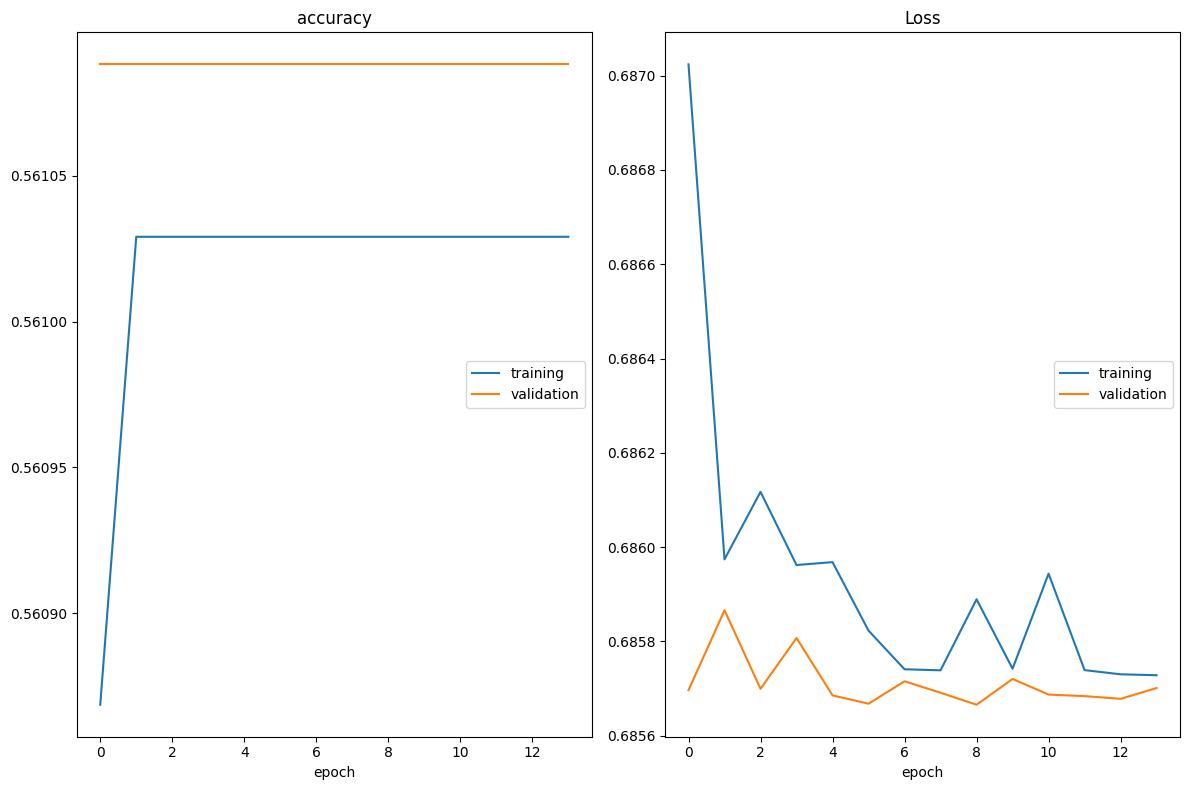

accuracy
	training         	 (min:    0.561, max:    0.561, cur:    0.561)
	validation       	 (min:    0.561, max:    0.561, cur:    0.561)
Loss
	training         	 (min:    0.686, max:    0.687, cur:    0.686)
	validation       	 (min:    0.686, max:    0.686, cur:    0.686)
1169/1169 [==============================] - 2s 1ms/step - loss: 0.6857 - accuracy: 0.5610 - val_loss: 0.6857 - val_accuracy: 0.5611


In [ ]:
model1.fit(all_X,all_y,'train','test', epochs = 100)